In [1]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import getpass
from hmmlearn import hmm
from functions import *
from random import shuffle
from random import seed
from graphviz import Digraph
from pymarkovchain import MarkovChain
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

### Summary of analysis

This notebook creates a HHM model for all student sequences in activity 2 using non blocked actions. To view HMM models of blocked sequences (and for multiple models for each group of students), check out the HMM_analysis_train_blocks_separately notebook.

### Loading the data

In [2]:
df = pd.read_csv('C:\Users\\'+getpass.getuser()+'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\MATCHING_phet_cck_user_actions+sophistication_WITHPAUSE_anonymized.txt')
df_scores = pd.read_csv('C:\Users\\'+getpass.getuser()+'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\MATCHING_phet_cck_user_data_anonymized.txt')
df["student"] = df["student"].astype('category')
df_scores["student"] = df_scores["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()

def remodel_families(row):
    if row["Family"] == "Build" or row["Family"] == "Revise":  # or row["Family"] == "Extra":
        if row["Outcome"] != "None":
            return "ConstructWithFeedback"
        else:
            return "Construct"
    else:
        return row["Family"]
    
df['Family'] = df.apply (lambda row: remodel_families (row),axis=1)

In [3]:
# from pivottablejs import pivot_ui
# pivot_ui(df)

### Some parameters

In [4]:
ACTIONS_TO_REMOVE = ['I','O','S']
ITERS = 300
RAND_INT = 2
seed(RAND_INT)
CUTOFF = 0.01
events = [e for e in ["T","S","O","F","P","I","E","X","C",] if e not in ACTIONS_TO_REMOVE]
blues = ["#c7e9b4","#7fcdbb","#41b6c4","#2c7fb8","#253494"]
greys = ['#d9d9d9','#bdbdbd','#969696','#737373','#525252']

### Declaring a few functions

In [27]:
translater = {e:events.index(e) for e in events}
decoder = {events.index(e):e for e in events}
decoder_plus = {"T":"Test","S":"Start","O":"Organize","F":"C.w.Feedback","P":"Pause","I":"Interface","E":"Extra","X":"Reset","C":"Construct"}

def state_labeller(state,emission):
    indices = list(np.where(emission[state]>0.05)[0])
    label = " +\n".join([decoder_plus[decoder[i]] + ' (' + str(int(emission[state,i]*100)) + '%)' for i in indices])
    return label
    
def get_color(w,color_set):
    def get_cmap(colors):
        return [(float(i)/len(colors),c) for i,c in enumerate(colors)]
    color = None
    for p,c in get_cmap(color_set):
        if w >= p:
            color = c
    return color

def prepare_data(blocks):
    shuffled_blocks = blocks.values()
    shuffle(shuffled_blocks)
    X = np.array( np.array([np.concatenate([  [int(translater[event]) for event in block.split(' ')] for block in shuffled_blocks])]).T )
    lengths = [len(b.split(' ')) for b in blocks.values()]
    return X, lengths

def split_data(X, lengths, split):
    n_train = int(len(lengths)*split)
    n_test = len(lengths) - n_train
    lengths_train, lengths_test = lengths[0:n_test], lengths[n_test:]
    X_train, X_test = X[0:sum(lengths_train)], X[sum(lengths_train):]
    return X_train, X_test, lengths_train, lengths_test

def get_model(X,lengths,n_states, iters=ITERS, random_state=RAND_INT):
    '''Note that all integers in the range of observations must be present in the data!!'''
    converged = False
    tries = 0
    while converged == False:
        model = hmm.MultinomialHMM(n_components=n_states,
                            n_iter = iters,
                            random_state = random_state).fit(X,lengths)
        converged = model.monitor_.converged
        tries += 1
    print "Model with {0} hidden states converged after {1} tries, with {2} iterations".format(n_states, tries, model.monitor_.iter)
    return model

def get_transition_probabilities(states_seq,lengths):
    cum_lengths = [l+sum(lengths[:i])-1 for i,l in enumerate(lengths)]
    seqs_states = [str(s)+" " if i not in cum_lengths else str(s)+"." for i,s in enumerate(states_seq)]
    seqs = ''.join(seqs_states)
    seqs = seqs[:-1]
    mc = MarkovChain()
    mc.generateDatabase(seqs)
    return mc.db

def draw_states_graph(model, cutoff = CUTOFF, label = True):
    states = Digraph('states')
    states.graph_attr.update(rankdir='LR')
    states.node_attr.update(shape='circle')
    for (i,j), p in np.ndenumerate(model.transmat_):
        if p >= cutoff:
            if label:
                states.edge(str(state_labeller(i,model.emissionprob_)),
                        str(state_labeller(j,model.emissionprob_)), 
                        color = get_color(p,blues), label = "{:.02f}".format(p), penwidth=str(5*p+2))
            else:
                states.edge(str(i), str(j), 
                    color = get_color(p,blues), label = "{:.02f}".format(p), penwidth=str(5*p+2))
    return states

def draw_hmm_graph(model, cutoff = CUTOFF, label = True, layout_circle=True):
    g = Digraph('G')
    if layout_circle:
        g.graph_attr.update(layout='circo')
    states = Digraph('states')
    states.node_attr.update(shape='circle',rank="max", fontsize='11')
    #Adding edge between hidden states
    for (i,j), p in np.ndenumerate(model.transmat_):
        if p >= cutoff:
            if label:
                states.edge(str(state_labeller(i,model.emissionprob_)),
                        str(state_labeller(j,model.emissionprob_)), 
                        color = get_color(p,blues), label = "{:.02f}".format(p), penwidth=str(5*p+2))
            else:
                states.edge(str(i), str(j), 
                        color = get_color(p,blues), label = "{:.02f}".format(p), penwidth=str(5*p+2))
    states.body.append('label = "states"')

    actions = Digraph('actions')
    actions.node_attr.update(shape='square')
    for (i,j), p in np.ndenumerate(model.emissionprob_):
        if p >= CUTOFF:
            if label:
                actions.edge(str(state_labeller(i,model.emissionprob_)),
                         str(decoder[j]), color = get_color(p,greys), 
                         label = "{:.02f}".format(p), penwidth=str(5*p+2))
            else:
                actions.edge(str(i), str(decoder[j]), color = get_color(p,greys), 
                         label = "{:.02f}".format(p), penwidth=str(5*p+2))
    actions.body.append('label = "actions"')
    actions.body.append('color=blue')

    g.subgraph(states);g.subgraph(actions)
    return g

def make_graph_from_chain(chain_probs):
    edge_labels={}
    G = nx.MultiDiGraph()
    for last_actions,probs in chain_probs.iteritems():
        if len(last_actions) == 1:
            last_action = last_actions[0]
            for next_action,p in probs.iteritems():
                G.add_edge(last_action, next_action, weight = p, label="{:.02f}".format(p))
            edge_labels[(last_action, next_action)] = label="{:.02f}".format(p)
    for u in G.nodes():
        for v in G.nodes():
            if (u,v) not in G.edges():
                G.add_edge(u,v, weight = 0, label = "0")
    G.remove_nodes_from(ACTIONS_TO_REMOVE)
    return G

def draw_hmm_graph_from_chain(chain_probs, cutoff = CUTOFF, label = True, layout_circle=True):
    g = Digraph('G')
    if layout_circle:
        g.graph_attr.update(layout='circo')
    states = Digraph('states')
    states.node_attr.update(shape='circle',rank="max", fontsize='11')
    #Adding edge between hidden states
    for last_actions,probs in chain_probs.iteritems():
        if len(last_actions) == 1:
            last_action = last_actions[0]
            for next_action,p in probs.iteritems():
                if next_action != ''  and last_action != '':
                    states.edge( str(state_labeller(last_action,model.emissionprob_)),  str(state_labeller(next_action,model.emissionprob_)), 
                        color = get_color(p,blues), label = "{:.02f}".format(p), penwidth=str(5*p+2))
    states.body.append('label = "states"')
    g.subgraph(states)
    return g

### Modelling
#### Getting the data
 First, we get the student actions in blocks and keep only the actions we care about. We also build a translator and decoder to pass the actions as discreet integers instead of strings. We are going to model the HMM on All the data from activity 2.

In [6]:
ACTIVITY = 'a2'
blocks = get_non_blocks(df[df.Activity==ACTIVITY],get_students(),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)

We concatenate the student actions into one array and computer their lengths. Since the student sequences might be stored in a specific order, we shuffle them first.

In [7]:
X, lengths = prepare_data(blocks)

Since we are modeling sequences of non blocked actions, it's a good idea to use cross validation to determine the optimal number of hidden states

In [8]:
# X_train, X_test, lengths_train, lengths_test = split_data(X, lengths, 0.6)
# scores = []
# models = []
# n_states = range(1,len(events)+3)
# print "Computing HMM model for 39 samples of observations"
# for n in n_states:
#     %time model = get_model(X_train, lengths_train, n)
#     scores.append(model.score(X_test, lengths = lengths_test))
#     models.append(model)

In [9]:
# bics = [-2*L + k*np.log(len(X_train)) for L,k in zip(scores, n_states)]
# plt.plot(n_states, bics,'-o')
# plt.title("BIC of models vs. number of hidden states in model")

### Analysis of model
Given that we want to trade off between the number of hidden states and the information gained, we pick the number of hidden states as 3 (which is where there is an elbow in the plot above). We store the transition and emition probabilities and visualize them. 

**Note**: We only draw edges with an emission or transition porbability greater than the CUTOFF variable declared above.

#### Let's look at out model.

In [10]:
N = 3
model = get_model(X, lengths, N)

Model with 3 hidden states converged after 1 tries, with 66 iterations


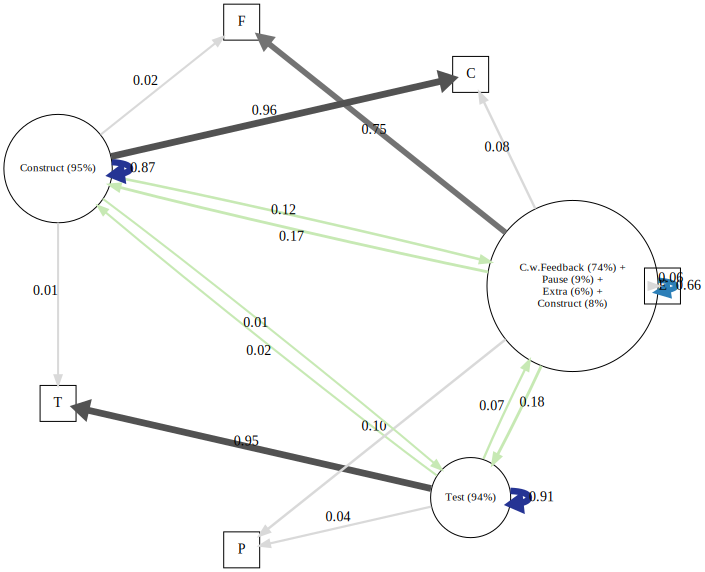

In [33]:
draw_hmm_graph(model)


### Analysis of student groups
Now we can apply the model to different groups and compare how the probabilities of transitions between states changes.
We store the transition and emition probabilities and visualize them. 
**Note**: We only draw edges with an emission or transition porbability greater than the CUTOFF variable declared above.

In [12]:
ACTIVITY = 'a2'
blocks_scaff = get_non_blocks(df[df.Activity==ACTIVITY],get_students("scaffolding","scaff"),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)
blocks_not = get_non_blocks(df[df.Activity==ACTIVITY],get_students("scaffolding","not"),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)
X_scaff, lengths_scaff = prepare_data(blocks_scaff)
X_not, lengths_not = prepare_data(blocks_not)

Using the previous model that was built on all student data, we predict the sequence of hidden states for two groups of students

In [13]:
states_scaff = model.predict(X_scaff, lengths = lengths_scaff)
states_not = model.predict(X_not, lengths = lengths_not)

Next we use Markov chains to find the probability of transitions between states for each student group

In [24]:
chain_probs_scaff = get_transition_probabilities(states_scaff, lengths_scaff)
chain_probs_not = get_transition_probabilities(states_not, lengths_not)

Finally we can draw the transitions using a graph

C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


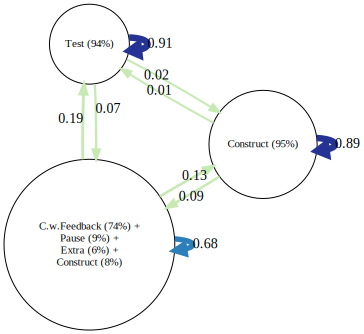

In [25]:
draw_hmm_graph_from_chain(chain_probs_scaff)

C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


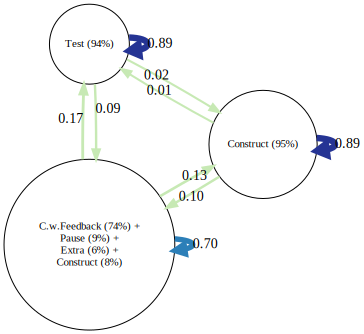

In [26]:
draw_hmm_graph_from_chain(chain_probs_not)

### Splitting by learning gains students

C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


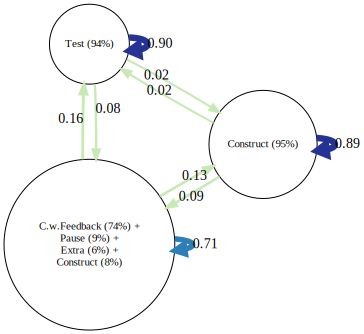

In [29]:
ACTIVITY = 'a2'
blocks_high = get_non_blocks(df[df.Activity==ACTIVITY],get_students("learning2","high"),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)
blocks_low = get_non_blocks(df[df.Activity==ACTIVITY],get_students("learning2","low"),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)
X_high, lengths_high = prepare_data(blocks_high)
X_low, lengths_low = prepare_data(blocks_low)

states_high = model.predict(X_high, lengths = lengths_high)
states_low = model.predict(X_low, lengths = lengths_low)
chain_probs_high = get_transition_probabilities(states_high, lengths_high)
chain_probs_low = get_transition_probabilities(states_low, lengths_low)

C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


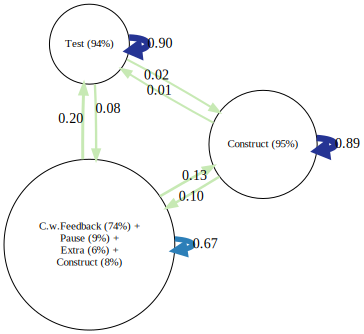

In [30]:
draw_hmm_graph_from_chain(chain_probs_high)

C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


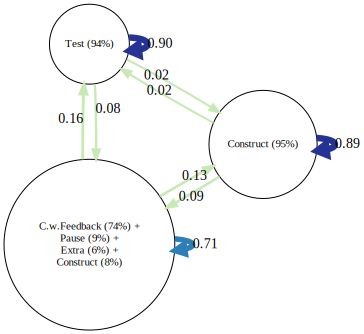

In [31]:
draw_hmm_graph_from_chain(chain_probs_low)